In [1]:
import torch
import torchvision
from torch.nn.functional import interpolate
import numpy as np
import os
import math

import matplotlib.pyplot as plt

from tqdm import tqdm

from improved_diffusion.script_util import  create_model_and_diffusion
from tqdm.notebook import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Model

In [ ]:
def pilimg_to_tensor(pil_img):
  t = torchvision.transforms.ToTensor()(pil_img)
  t = 2*t-1 # [0,1]->[-1,1]
  t = t.unsqueeze(0)
  t = t.to(device)
  return(t)

def display_as_pilimg(t, labels):
    """
    Display a tensor as an image using Matplotlib with labels.

    Parameters:
    t (torch.Tensor): The input tensor containing the images.
    labels (list of str): The labels for each image.
    
    Returns:
    None
    """
    t = 0.5 + 0.5 * t.to('cpu')
    t = t.squeeze()
    t = t.clamp(0., 1.).detach()

    # Number of images
    num_images = t.shape[2] // t.shape[1]

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))
    
    if num_images>1:
      for i, ax in enumerate(axes):
          img = t[:, :, i * t.shape[1]:(i + 1) * t.shape[1]]
          ax.imshow(img.permute(1, 2, 0))
          ax.set_title(labels[i])
          ax.axis('off')
    else:
      img = t
      axes.imshow(img.permute(1, 2, 0))
      axes.set_title(labels[0])
      axes.axis('off')

    plt.show()

## Load DDPM UNet

In [ ]:
config = {
    'image_size': 256,
    'num_channels': 192,
    'num_res_blocks': 3,
    'diffusion_steps': 1000,
    'noise_schedule': 'cosine',
    'num_heads': 4,
    'num_heads_upsample': -1,
    'attention_resolutions': "16,8",
    'dropout': 0.0,
    'learn_sigma': False,
    'sigma_small': False,
    'class_cond': False,
    'timestep_respacing': "",
    'use_kl': False,
    'predict_xstart': False,
    'rescale_timesteps': True,
    'rescale_learned_sigmas': True,
    'use_checkpoint': False,
    'use_scale_shift_norm': True,
}

In [ ]:
model, diffusion = create_model_and_diffusion(
    **config
)
model.load_state_dict(torch.load(os.getcwd() + "/models/model_Ideal_525k/ema_0.9999_525k.pt", map_location='cpu'))
model = model.to(device)
# use in eval mode:
model.eval();

In [ ]:
# Print the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters in the model: {count_parameters(model)}")

Number of parameters in the model: 369547779


In [ ]:
# Function to define the beta cosine scheduling

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                    produces the cumulative product of (1-beta) up to that
                    part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                    prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

In [ ]:
class DDPM:
  def __init__(self, model=model, DDIM=False):
    self.num_diffusion_timesteps = 1000
    self.reversed_time_steps = np.arange(self.num_diffusion_timesteps)[::-1]
    beta_start = 0.0001
    beta_end = 0.02
    #self.betas = np.linspace(beta_start, beta_end, self.num_diffusion_timesteps, dtype=np.float64)   # linear scheduling, we use the cosine one
    self.betas = betas_for_alpha_bar(
            self.num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )   # cosine scheduling
    self.alphas = 1.0 - self.betas
    self.alphas_cumprod = np.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
    self.model = model
    self.imgshape = (1,3,256,256)
    self.DDIM = DDIM

  def get_eps_from_model(self, x, t):
    # the model outputs:
    # - an estimation of the noise eps (channels 0 to 2)
    # - learnt variances for the posterior  (channels 3 to 5)
    # (see Improved Denoising Diffusion Probabilistic Models
    # by Alex Nichol, Prafulla Dhariwal
    # for the parameterization)
    # We discard the second part of the output for this practice session.
    model_output = self.model(x, torch.tensor(t, device=device).unsqueeze(0))
    model_output = model_output[:,:3,:,:]
    return(model_output)

  def predict_xstart_from_eps(self, x, eps, t):
    x_start = (
        np.sqrt(1.0 / self.alphas_cumprod[t])* x
        - np.sqrt(1.0 / self.alphas_cumprod[t] - 1) * eps
    )
    x_start = x_start.clamp(-1.,1.)
    return(x_start)

  def sample(self, show_steps=True):
    with torch.no_grad():  # avoid backprop wrt model parameters
        xt = torch.randn(self.imgshape, device=device)  # initialize x_t for t=T
        for i, t in enumerate(self.reversed_time_steps):
            alpha_t = self.alphas[t]
            alpha_bar_t = self.alphas_cumprod[t]
            alpha_bar_prev_t = self.alphas_cumprod_prev[t]

            eps = self.get_eps_from_model(xt, t)
            xhat = self.predict_xstart_from_eps(xt, eps, t)

            if self.DDIM:
                # Using the deterministic path for DDIM
                x0_pred = self.predict_xstart_from_eps(xt, eps, t)
                # Update xt using the deterministic DDIM update
                if t > 0:
                    xt = np.sqrt(alpha_bar_prev_t) * x0_pred + np.sqrt(1 - alpha_bar_prev_t) * eps
            else:
                # Standard DDPM update with noise
                #z = torch.randn(self.imgshape, device=device) if t > 1 else torch.zeros(self.imgshape, device=device)
                #sigma_t = np.sqrt(self.betas[t])
                #xt = 1 / np.sqrt(alpha_t) * (xt - (1 - alpha_t) / np.sqrt(1 - alpha_bar_t) * eps) + sigma_t * z

                beta_t = self.betas[t]
                sigma_t = np.sqrt(beta_t)

                z = torch.randn(self.imgshape, device=device) if t > 1 else torch.zeros(self.imgshape, device=device)

                xt = np.sqrt(alpha_t) * (1-alpha_bar_prev_t) / (1-alpha_bar_t) * xt
                xt += np.sqrt(alpha_bar_prev_t)*beta_t / (1-alpha_bar_t)*xhat
                xt += sigma_t*z


            if show_steps and t % 200 == 0:
                print('Iteration:', t)
                labels = [r"Diffusion step x_t", r"Prediction $x_{hat}$"]
                pilimg = display_as_pilimg(torch.cat((xt, self.predict_xstart_from_eps(xt, eps, t)), dim=3)[:,:3], labels)

    return xt

  
  def posterior_sampling(self, linear_operator, y, x_true=None, show_steps=True, vis_y=None):
      if vis_y is None:
          vis_y = y

      # Initialize xt for t=T
      x = torch.randn(self.imgshape, device=device)
      x.requires_grad = True

      for t in tqdm(self.reversed_time_steps[1:]):  # Start from the last timestep

          alpha_t = self.alphas[t]
          alpha_bar_t = self.alphas_cumprod[t]
          alpha_bar_tm1 = self.alphas_cumprod_prev[t]

          eps = self.get_eps_from_model(x, t)
          xhat = self.predict_xstart_from_eps(x, eps, t)

          if self.DDIM:
            # Using DDIM, update x deterministically
            if t > 0:
                x_prime = np.sqrt(alpha_bar_tm1) * xhat + np.sqrt(1 - alpha_bar_tm1) * eps
            else:
                x_prime = xhat  # At the last step, we converge to the deterministic prediction

          else:
            if t > 0:
              beta_t = self.betas[t]
              sigma_t = np.sqrt(beta_t)

              z = torch.randn(self.imgshape, device=device)

              x_prime = np.sqrt(alpha_t) * (1-alpha_bar_tm1) / (1-alpha_bar_t) * x
              x_prime += np.sqrt(alpha_bar_tm1)*beta_t / (1-alpha_bar_t)*xhat
              x_prime += sigma_t*z

              df_term = torch.sum((y-linear_operator(xhat))**2)
              grad = torch.autograd.grad(df_term, x)[0]
              zeta = 1 / torch.sqrt(df_term)

              x = x_prime - zeta * grad 
            else:
              x = xhat
            


          if show_steps and ((t)%200==0):
            print('Iteration :', t)
            if t==0:
              labels = [r"Diffusion step $x_0$", r"Processed $x_0$", r"Observation $y$", r"True $x_0$"]
              pilimg = display_as_pilimg(torch.cat((x, interpolate(linear_operator(x), size=(256, 256), mode='bilinear', align_corners=False), interpolate(y, size=(256, 256), mode='bilinear', align_corners=False), interpolate(x_true, size=(256, 256), mode='bilinear', align_corners=False)), dim=3), labels)
            else:
              labels = [r"Diffusion step $x_t$", r"Prediction $x_{hat}$", r"Processed $x_{hat}$", r"Observation $y$", r"True $x_0$"]
              pilimg = display_as_pilimg(torch.cat((x, xhat, interpolate(linear_operator(xhat), size=(256, 256), mode='bilinear', align_corners=False), interpolate(y, size=(256, 256), mode='bilinear', align_corners=False), interpolate(x_true, size=(256, 256), mode='bilinear', align_corners=False)), dim=3), labels)
          else:
            if t==0:
              labels = [r"Diffusion step $x_0$", r"Observation $y$", r"True $x_0$"]
              pilimg = display_as_pilimg(torch.cat((x, interpolate(y, size=(256, 256), mode='bilinear', align_corners=False), interpolate(x_true, size=(256, 256), mode='bilinear', align_corners=False)), dim=3), labels)

      return x



ddpm = DDPM(DDIM=False)

# Sampling

In [ ]:
sample = ddpm.sample(show_steps=False)

display_as_pilimg(sample, ["Sample"])

# Conditional sampling for imaging inverse problems

## Pixels scaling and Redshift

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import astropy.units
from astropy.cosmology import Planck15
from scipy.ndimage import zoom
from astropy.nddata import block_reduce

# Pixel conversion factors
pixel_conversion = {
    'HSC': 0.17 * astropy.units.arcsec,  # arcsec / pixel
    'JWST': 0.03 * astropy.units.arcsec  # arcsec / pixel
}

# Create an instance of the Planck 2015 cosmology
cosmo = Planck15

def summarize_cosmology():
    # Access various cosmological parameters
    H0 = cosmo.H0  # Hubble constant in km/s/Mpc
    Omega_m = cosmo.Om0  # Matter density parameter
    Omega_lambda = cosmo.Ode0  # Dark energy density parameter

    print("Hubble constant (H0):", H0)
    print("Matter density parameter (Omega_m):", Omega_m)
    print("Dark energy density parameter (Omega_lambda):", Omega_lambda)

def histogram(data, **hist_kwargs):
    data_hist = data.flatten()
    plt.hist(data_hist.numpy(), **hist_kwargs)

def plot_image(image_data, vmin=None, vmax=None, title=''):
    if vmin is None: vmin = torch.min(image_data)
    if vmax is None: vmax = torch.max(image_data)
    fig = plt.gcf()
    fig.set_size_inches(5, 5)
    plt.imshow(image_data.permute(1, 2, 0).cpu().numpy(), vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.show()

def arcsec_to_radian(x):
    return np.pi / 648000 * x

def radian_to_arcsec(x):
    return x / (np.pi / 648000)

def get_down_scale_factor(z=0.1, unit_pixel_in_kpc=0.4, experiment='HSC'):
    """
    Returns the scale factor at which the image has to be decreased for a given redshift.
    If the scale factor is >1, we decrease the image size.
    """
    arcsec_per_kpc_at_z = Planck15.arcsec_per_kpc_proper(z)
    unit_pixel = unit_pixel_in_kpc * astropy.units.kpc
    down_scale_factor = 1 / unit_pixel * pixel_conversion[experiment] / arcsec_per_kpc_at_z

    if down_scale_factor.unit == '':
        return down_scale_factor.value
    else:
        raise ValueError("Error, factor carries a unit.")

def get_image_in_janski(image_data, z):
    unit_pixel_in_kpc = 0.4
    unit_pixel = unit_pixel_in_kpc * astropy.units.kpc
    pixel_width_in_arcsec = Planck15.arcsec_per_kpc_proper(z) * unit_pixel
    image_in_janskis = pixel_width_in_arcsec.value ** 2 * image_data
    return image_in_janskis

def get_downscaled_image_at_z_in_janski(image_data, z, experiment='HSC', use_zoom_func=False):
    image_data_in_janski = get_image_in_janski(image_data, z=z)
    reduce_factor = get_down_scale_factor(z, experiment=experiment)

    if use_zoom_func:
        scale_factor = 1 / reduce_factor
        new_size = (int(image_data_in_janski.shape[-2] * scale_factor), int(image_data_in_janski.shape[-1] * scale_factor))
        image_smaller = F.interpolate(image_data_in_janski, size=new_size, mode='bilinear', align_corners=False)
    else:
        # Not yet implemented in pytorch version
        image_smaller = block_reduce(image_data_in_janski, (1, 1, reduce_factor, reduce_factor))

    return image_smaller

def normalize_min_max_func(x):
    """
    Normalize each channel of the tensor to the range [0, 1].
    
    Parameters:
    x (torch.Tensor): The input tensor.
    
    Returns:
    torch.Tensor: The normalized tensor.
    """
    min_val = x.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
    max_val = x.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
    return (x - min_val) / (max_val - min_val + 1e-18)

def _ScaleImage(img, z=0.1, experiment='HSC', new_size=256, normalize_min_max=True):
    """
    A function that converts the image as a tensor to the desired format.
    """
    rescaled_image = get_downscaled_image_at_z_in_janski(
        image_data=img,
        z=z,
        experiment=experiment,
        use_zoom_func=True
    )

    if not isinstance(rescaled_image, torch.Tensor):
        rescaled_image = torch.from_numpy(rescaled_image) if isinstance(rescaled_image, np.ndarray) else torch.tensor(rescaled_image)

    # Resize and crop or pad the image to the new size
    #rescaled_image = rescaled_image.unsqueeze(0).unsqueeze(0) if rescaled_image.dim() == 2 else rescaled_image.unsqueeze(0)
    #rescaled_image = F.interpolate(rescaled_image, size=(new_size, new_size), mode='bilinear', align_corners=False)

    if normalize_min_max:
        return normalize_min_max_func(rescaled_image)
    else:
        return rescaled_image

## Tests

In [ ]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [ ]:
from astropy.io import fits
import torchvision.transforms.functional as TF

# Put the folder were there are TNG fits files
file = fits.open('/gpfsstore/rech/tkc/commun/fits_stuff/tng100/11_7/idealized/88/shalo_088-2_v1_HSC_GRIZY.fits')

PSF_g = file[3].data
PSF_r = file[7].data
PSF_i = file[11].data

from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize, SinhStretch, LogStretch, LinearStretch, AsinhStretch)

interval = MinMaxInterval()
transform = AsinhStretch(a=0.01) + interval

r = file[0].data
g = file[4].data
b = file[8].data

r = 10 ** ((22.5 - 2.5*np.log10(np.maximum(1e-11,r)) - 8.9) / (-2.5))
g = 10 ** ((22.5 - 2.5*np.log10(np.maximum(1e-11,g)) - 8.9) / (-2.5))
b = 10 ** ((22.5 - 2.5*np.log10(np.maximum(1e-11,b)) - 8.9) / (-2.5))

# Apply MinMaxInterval and SqrtStretch to each channel separately
r = transform(crop_center(r, 258, 258))
g = transform(crop_center(g, 258, 258))
b = transform(crop_center(b, 258, 258))

rgb_image = np.dstack((r, g, b))

x_realistic = pilimg_to_tensor(rgb_image)

In [ ]:
# Average train set values to reverse the minmax normalization

max_r, max_g, max_b = 4.1556867948239864e-07, 1.3491573542387314e-06, 2.6782236060862626e-06
min_r, min_g, min_b = 3.6307805477010026e-17, 3.6307805477010026e-17, 3.6307805477010026e-17

In [ ]:
x_smallest = min(file[3].data.shape[0], file[7].data.shape[0], file[11].data.shape[0])
y_smallest = min(file[3].data.shape[1], file[7].data.shape[1], file[11].data.shape[1])

PSF_g = crop_center(file[3].data, y_smallest, x_smallest)
PSF_r = crop_center(file[7].data, y_smallest, x_smallest)
PSF_i = crop_center(file[11].data, y_smallest, x_smallest)


psf_kernel = torch.from_numpy(np.dstack((PSF_g, PSF_r, PSF_i)).transpose((2,0,1))).float()

In [ ]:
z = file[0].header['REDSHIFT']

def pre_process(img, z=z, experiment='HSC', new_size=256, normalize_min_max=True):
    return _ScaleImage((img+1)/2, experiment=experiment, new_size=new_size, z=z, normalize_min_max=normalize_min_max)*2 - 1

def pre_process2(img, z=z, experiment='HSC', new_size=256, normalize_min_max=False):
    return _ScaleImage(img, experiment=experiment, new_size=new_size, z=z, normalize_min_max=normalize_min_max)

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import numpy as np


def apply_psf_kernel(x, psf_kernel=psf_kernel):
    """
    Applies the provided PSF kernel to each channel of a tensor x.
    
    Parameters:
    - x (torch.Tensor): The input tensor of shape [N, C, H, W].
    - psf_kernel (torch.Tensor): The PSF kernel of shape [C, kernel_size, kernel_size].
    
    Returns:
    - torch.Tensor: The tensor after applying the PSF kernel.
    """

    device = x.device  # Get the device from the input tensor
    channels = x.size(1)  # Assuming x has shape [N, C, H, W]
    original_size = x.shape[2:]
    
    # Ensure the PSF kernel has the shape [C, 1, kernel_size, kernel_size]
    if psf_kernel.dim() == 3:
        psf_kernel = psf_kernel.unsqueeze(1).to(device)
    
    # Apply convolution using the multi-channel PSF kernel
    kernel_size = psf_kernel.size(2)  # Assuming square kernels
    padding = kernel_size // 2
    x_psf = F.conv2d(x, psf_kernel, padding=padding, groups=channels)
    x_psf = TF.center_crop(x_psf, original_size)
    
    return x_psf.float()

In [ ]:
def normalize_min_max_func2(x):
    """
    Normalize each channel of the tensor to the range [0, 1].
    
    Parameters:
    x (torch.Tensor): The input tensor.
    
    Returns:
    torch.Tensor: The normalized tensor.
    """
    min_val = x.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
    max_val = x.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
    return (x - min_val) / (max_val - min_val + 1e-18)

def inverse_normalize_min_max_func2(x, min_r=min_r, min_g=min_g, min_b=min_b, max_r=max_r, max_g=max_g, max_b=max_b):
    """
    Reverse the normalization applied by normalize_min_max_func2.
    
    Parameters:
    x (torch.Tensor): The input tensor to be denormalized.
    min_r, min_g, min_b (float): Minimum values for the red, green, and blue channels respectively.
    max_r, max_g, max_b (float): Maximum values for the red, green, and blue channels respectively.
    
    Returns:
    torch.Tensor: The denormalized tensor.
    """
    # Create tensors for min and max values for each channel
    min_vals = torch.tensor([min_r, min_g, min_b], device=x.device).view(-1, 1, 1)
    max_vals = torch.tensor([max_r, max_g, max_b], device=x.device).view(-1, 1, 1)
    
    # Reverse the normalization
    return (x * (max_vals - min_vals) + min_vals).float()

In [ ]:
def asinh_stretch(tensor, a):
    """
    Apply the asinh stretch to the input tensor.
    
    Parameters:
    tensor (torch.Tensor): The input tensor to be stretched.
    a (float): The stretch parameter.
    
    Returns:
    torch.Tensor: The asinh stretched tensor.
    """
    return torch.asinh(tensor / a) / torch.asinh(torch.tensor(1.0 / a))

def inverse_asinh_stretch(tensor, a):
    """
    Apply the inverse of the asinh stretch to the input tensor.
    
    Parameters:
    tensor (torch.Tensor): The input tensor to be inversely stretched.
    a (float): The stretch parameter.
    
    Returns:
    torch.Tensor: The inverse asinh stretched tensor.
    """
    return a * torch.sinh(tensor * torch.asinh(torch.tensor(1.0 / a)))

def composition2(x, func1 = pre_process2, func2 = apply_psf_kernel, a1 = 0.01, a2 = 0.005):
    return normalize_min_max_func2(asinh_stretch(func2(func1(inverse_asinh_stretch(inverse_normalize_min_max_func2((x+1)/2), a1))), a2))*2 - 1

def composition(x, func1 = pre_process2, func2 = apply_psf_kernel):
    return func2(func1(x))

In [ ]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radius
    return mask  # Return a 2D mask, no need to stack here

def compute_mean_in_circular_region(image, radius=30):
    # image is expected to be of shape (h, w, 3) - three color channels
    h, w, _ = image.shape
    mask = create_circular_mask(h, w, radius=radius)

    masked_means = []
    
    # Apply the mask to each channel separately
    for i in range(3):  # Iterate over RGB channels
        masked_channel = image[:, :, i][mask]  # Apply mask to the ith channel
        masked_means.append(np.mean(masked_channel))  # Compute the mean for the masked region

    return np.mean(masked_means)  # Return the mean

Average SNR in central circular region:  699.290158115195
redshift-pixel scaled


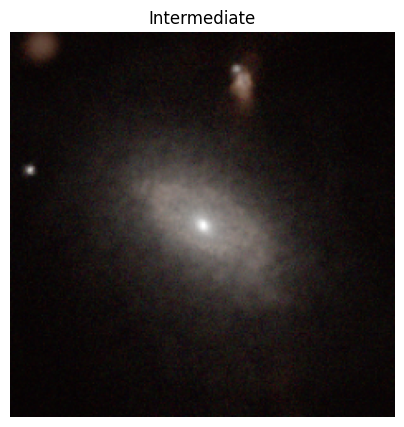

noisy measurement


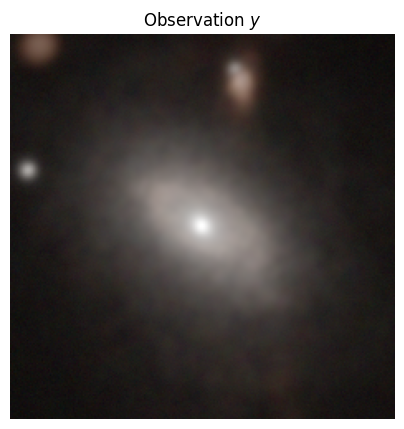

In [ ]:
from astropy.io import fits

file = fits.open('/gpfsstore/rech/tkc/commun/fits_stuff/tng100/11_7/idealized/88/shalo_088-2_v1_photo.fits')


from astropy.visualization import (MinMaxInterval, AsinhStretch)

r = file[1].data
g = file[2].data
b = file[4].data

interval = MinMaxInterval()
transform = interval
transform2 = AsinhStretch(a=0.001) + interval

# Transform Magnitude to Janski

r = 10 ** ((r - 8.9) / (-2.5))
g = 10 ** ((g - 8.9) / (-2.5))
b = 10 ** ((b - 8.9) / (-2.5))

# Change pixel scaling

unit_pixel = 1/4

r = zoom(r, unit_pixel)
g = zoom(g, unit_pixel)
b = zoom(b, unit_pixel)

# Compute old flux

old_flux_r = np.sum(r)
old_flux_g = np.sum(g)
old_flux_b = np.sum(b)

x_true = pilimg_to_tensor(np.dstack((transform2(crop_center(r, 256, 256)), transform2(crop_center(g, 256, 256)), transform2(crop_center(b, 256, 256)))))

sizes = pre_process(x_true).shape[2:]

y_1 = pilimg_to_tensor(np.dstack((transform2(pre_process2(torch.tensor(crop_center(r, 256, 256)).unsqueeze(0).unsqueeze(0)).squeeze(0)[0].numpy()), transform2(pre_process2(torch.tensor(crop_center(g, 256, 256)).unsqueeze(0).unsqueeze(0)).squeeze(0)[0].numpy()), transform2(pre_process2(torch.tensor(crop_center(b, 256, 256)).unsqueeze(0).unsqueeze(0)).squeeze(0)[0].numpy()))))

# Apply pre-processing and PSF

r = composition(torch.tensor(r).unsqueeze(0).unsqueeze(0)).squeeze(0)[0].numpy()
g = composition(torch.tensor(g).unsqueeze(0).unsqueeze(0)).squeeze(0)[0].numpy()
b = composition(torch.tensor(b).unsqueeze(0).unsqueeze(0)).squeeze(0)[0].numpy()

# Normalize

# The magnitude (here 18) can be changed
mag_21 = 10 ** ((18 - 8.9) / (-2.5))

r = r*0.167**2*sizes[0]**2*mag_21/old_flux_r
g = g*0.167**2*sizes[0]**2*mag_21/old_flux_g
b = b*0.167**2*sizes[0]**2*mag_21/old_flux_b

r = crop_center(r, 512, 512)
g = crop_center(g, 512, 512)
b = crop_center(b, 512, 512)

# Apply noise

sigma_noise = 2.0302566460297157e-09

r = r + sigma_noise * np.random.randn(*r.shape)
g = g + sigma_noise * np.random.randn(*g.shape)
b = b + sigma_noise * np.random.randn(*b.shape)

SNR_in_circular_region = compute_mean_in_circular_region(np.dstack((r, g, b)))

print("Average SNR in central circular region: ", SNR_in_circular_region/sigma_noise)

# Stretch

transform = AsinhStretch(a=0.001) + interval

r = transform(r)
g = transform(g)
b = transform(b)

# Stack arrays into a 3D array for RGB image
rgb_image = np.dstack((r, g, b))

x_noisy = pilimg_to_tensor(rgb_image)
y = TF.center_crop(x_noisy, pre_process(x_true).shape[2:])

print("redshift-pixel scaled")
display_as_pilimg(y_1, labels=[r"Intermediate"]);

print("noisy measurement")
display_as_pilimg(y, labels=[r"Observation $y$"]);

In [ ]:
def compute_mean_in_circular_region(image):
    # Assume all images have the same dimensions
    h, w = image.shape
    mask = create_circular_mask(h, w, radius=30)

    masked_means = []
    masked_img = image[mask]  # Apply the mask

    return np.mean(masked_img)  # Return the average

Idealized image


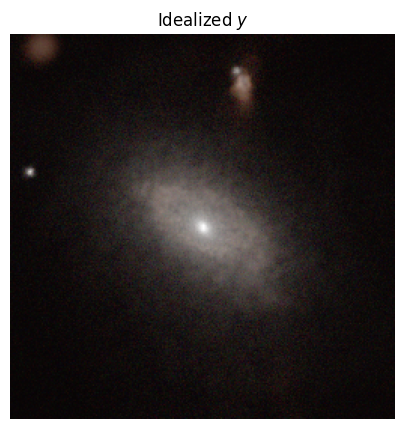

In [ ]:
print("Idealized image")
display_as_pilimg(x_true, labels=[r"Idealized $y$"]);

Realistic image


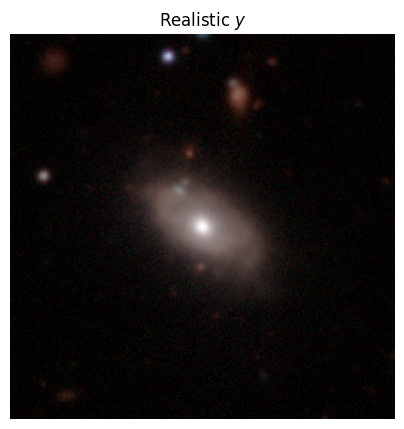

In [ ]:
print("Realistic image")
display_as_pilimg(x_realistic, labels=[r"Realistic $y$"]);

  0%|          | 0/999 [00:00<?, ?it/s]

Iteration : 800


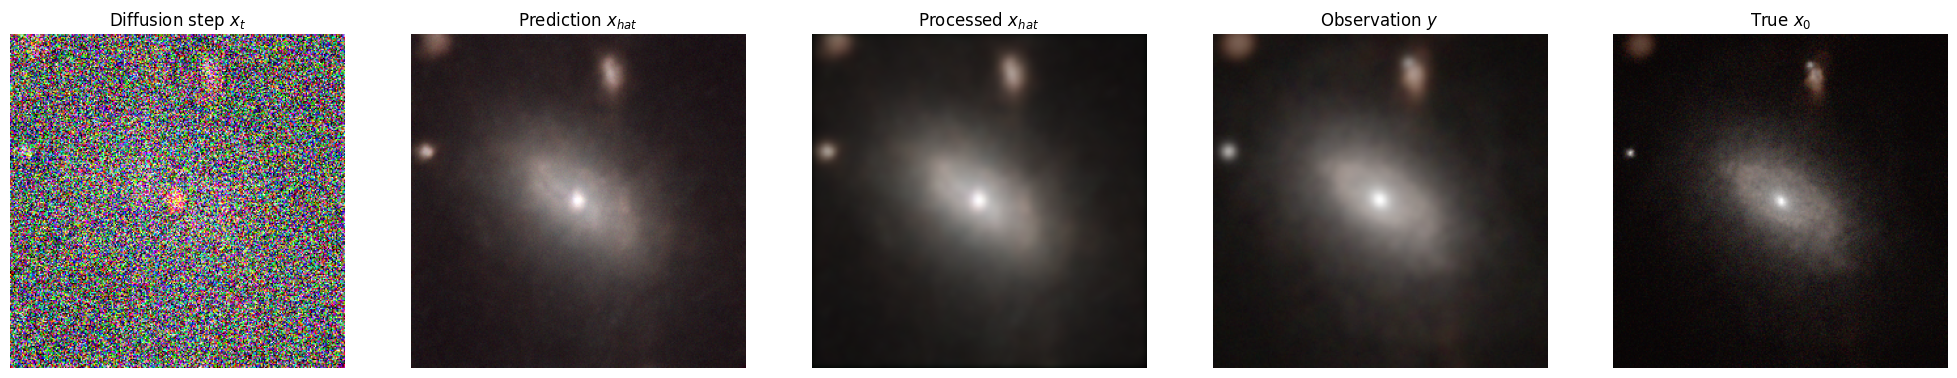

In [ ]:
restored_image = ddpm.posterior_sampling(composition2, y, x_true=x_true, show_steps=True)

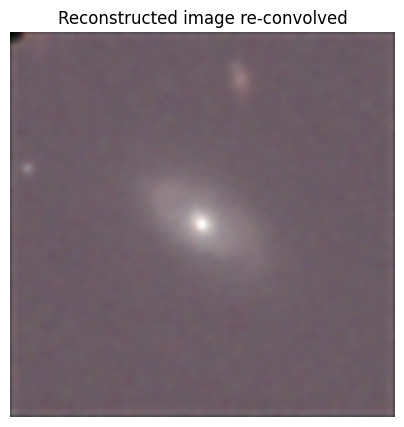

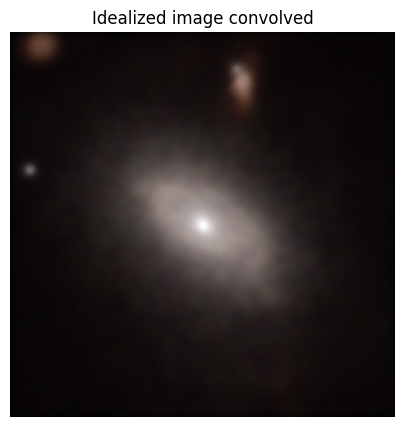

In [ ]:
display_as_pilimg(composition2(restored_image), labels=["Reconstructed image re-convolved"]);
display_as_pilimg(composition2(x_true, a1 = 0.001), labels=["Idealized image convolved"]);